In [0]:
#Creating spark session for the app
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField,StructType,IntegerType,BooleanType,DateType,DecimalType,StringType
from pyspark.sql.functions import col,when,avg,sum,row_number,count,year,month,dayofmonth,trim,lower,isnull,desc,asc,round,floor,ceil
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
spark = SparkSession.builder.appName("IPL Data Analysis").getOrCreate()

In [0]:
ball_by_ball_Schema = StructType([
    StructField("match_id",IntegerType(),True),
    StructField("inning",IntegerType(),True),
    StructField("batting_team",StringType(),True),
    StructField("bowling_team",StringType(),True),
    StructField("over",IntegerType(),True),
    StructField("ball",IntegerType(),True),
    StructField("batter",StringType(),True),
    StructField("bowler",StringType(),True),
    StructField("non_striker",StringType(),True),
    StructField("batsman_runs",IntegerType(),True),
    StructField("extra_runs",IntegerType(),True),
    StructField("total_runs",IntegerType(),True),
    StructField("extras_type",StringType(),True),
    StructField("is_wicket",IntegerType(),True),
    StructField("player_dismissed",StringType(),True),
    StructField("dismissal_kind",StringType(),True),
    StructField("fielder",StringType(),True)    
])

In [0]:
ball_by_ball_df = spark.read.schema(ball_by_ball_Schema).format("csv").option("header","true").option("inferSchema","true").load("s3://ipl-data-analysis-with-spark/deliveries.csv")

In [0]:
matches_df_Schema = StructType([
    StructField("id",IntegerType(),True),
    StructField("season",StringType(),True),
    StructField("city",StringType(),True),
    StructField("date",DateType(),True),
    StructField("match_type",StringType(),True),
    StructField("player_of_match",StringType(),True),
    StructField("venue",StringType(),True),
    StructField("team1",StringType(),True),
    StructField("team2",StringType(),True),
    StructField("toss_winner",StringType(),True),
    StructField("toss_decision",StringType(),True),
    StructField("winner",StringType(),True),
    StructField("result",StringType(),True),
    StructField("result_margin",IntegerType(),True),
    StructField("target_runs",IntegerType(),True),
    StructField("target_overs",IntegerType(),True),
    StructField("super_over",StringType(),True),
    StructField("method",StringType(),True),
    StructField("umpire1",StringType(),True),
    StructField("umpire2",StringType(),True)
])

In [0]:
matches_df = spark.read.schema(matches_df_Schema).format("csv").option("header","true").option("inferSchema","true").load("s3://ipl-data-analysis-with-spark/matches.csv")

In [0]:
#Aggregation : Calculating total runs scored in each match & Average runs scored in each inning
total_and_Average_runs = ball_by_ball_df.groupby('match_id','inning').agg(
    sum('batsman_runs').alias('Total_Runs'),
    avg('batsman_runs').alias('Average_Runs')
)

#Finding players who hit most no of sixes
most_sixes = ball_by_ball_df.filter( ball_by_ball_df.batsman_runs == 6 ).groupby('batter').agg(
    count('batsman_runs').alias('Sixes_Hit')
).sort(desc('Sixes_Hit'))

#Finding players who hit most no of fours
most_fours = ball_by_ball_df.filter( ball_by_ball_df.batsman_runs == 4 ).groupby('batter').agg(
    count('batsman_runs').alias('Fours_Hit')
).sort(desc('Fours_Hit'))

#Finding players who hit most no of boundaries
most_boundaries = ball_by_ball_df.filter( (ball_by_ball_df.batsman_runs == 4) | (ball_by_ball_df.batsman_runs == 6) ).groupby('batter').agg(
    count('batsman_runs').alias('Boundaries_Hit')
).sort(desc('Boundaries_Hit'))

#Finding top run scorers
most_runs = ball_by_ball_df.groupby('batter').agg(
    sum('batsman_runs').alias('Runs')
).sort(desc('Runs'))

#Finding players who took most no of wickets
most_wickets = ball_by_ball_df.filter( (ball_by_ball_df.is_wicket == 1) & (ball_by_ball_df.dismissal_kind != 'run out') ).groupby('bowler').agg(
    count('is_wicket').alias('Total_Wickets')
).sort(desc('Total_Wickets'))

#Most wickets in a single IPL Season
most_wickets_in_an_IPL_Season = ball_by_ball_df.join( matches_df, ball_by_ball_df.match_id == matches_df.id, "inner"  ).filter( (ball_by_ball_df.is_wicket == 1) & (ball_by_ball_df.dismissal_kind != 'run out') ).groupby('bowler','season').agg(
    count('is_wicket').alias('Most_Wickets_in_a_Single_IPL_Season')
).sort(desc('Most_Wickets_in_a_Single_IPL_Season'))

#purple Cap Holders List across all IPL Seasons
windowSpec = Window.partitionBy('season').orderBy(desc('Most_Wickets_in_a_Single_IPL_Season'))
purple_cap_all_seasons = most_wickets_in_an_IPL_Season.withColumn(
    "rank",
    row_number().over(windowSpec)
)
purple_cap_all_seasons = purple_cap_all_seasons.filter( purple_cap_all_seasons.rank == 1 )

#Finding players with most runs in a single IPL Season
most_runs_in_an_IPL_season = ball_by_ball_df.join( matches_df, ball_by_ball_df.match_id == matches_df.id, "inner"  ).groupby('batter','season').agg(
    sum('batsman_runs').alias('Most_Runs_in_a_Single_IPL_Season')
).sort(desc('Most_Runs_in_a_Single_IPL_Season'))

#Orange Cap Holders List across all IPL Seasons
windowSpec_ = Window.partitionBy('season').orderBy(desc('Most_Runs_in_a_Single_IPL_Season'))
orange_cap_all_seasons = most_runs_in_an_IPL_season.withColumn(
    "rank",
    row_number().over(windowSpec_)
)
orange_cap_all_seasons = orange_cap_all_seasons.filter( orange_cap_all_seasons.rank == 1 )


#Most no of catches
most_catches = ball_by_ball_df.filter( (ball_by_ball_df.is_wicket == 1) & (ball_by_ball_df.dismissal_kind == 'caught') ).groupby('fielder').agg(
    count('is_wicket').alias('Catches')
).sort(desc('Catches'))

#Most no of stumpings
most_stumpings = ball_by_ball_df.filter( (ball_by_ball_df.is_wicket == 1) & (ball_by_ball_df.dismissal_kind == 'stumped') ).groupby('fielder').agg(
    count('is_wicket').alias('Stumpings')
).sort(desc('Stumpings'))

#most economical bowler in powerplay
most_economical_baller_in_powerplay = ball_by_ball_df.filter( (ball_by_ball_df.over <= 6)  ).groupby('bowler').agg(
    (round((avg('total_runs') * 6.0),2)).alias('Economy_in_Powerplay'),
    (round(( count('total_runs') / 6.0),2)).alias('Overs_Bowled_in_Powerplay')
)
most_economical_baller_in_powerplay = most_economical_baller_in_powerplay.filter(most_economical_baller_in_powerplay.Overs_Bowled_in_Powerplay >= 50).sort(asc('Economy_in_Powerplay'))

In [0]:
#Transformation-01 : Filtering out wides & No-balls
ball_by_ball_df = ball_by_ball_df.filter(
    (ball_by_ball_df.extras_type == 'byes') | (ball_by_ball_df.extras_type == 'legbyes') | (ball_by_ball_df.extras_type == 'penalty') | (ball_by_ball_df.extras_type.isNull())
)

#Transformation-02 : Calculate running score using Window functions 
windowSpec = Window.partitionBy('match_id','inning').orderBy('over','ball')
ball_by_ball_df = ball_by_ball_df.withColumn(
    "runningScorePerInning",
    sum('total_runs').over(windowSpec)
)

#Transformation-03 : Flagging a delivery as 'High-Impact' incase >=6 runs are scored of it or a wicket fell.
ball_by_ball_df = ball_by_ball_df.withColumn(
    "high_Impact",
    when( (col('total_runs') >= 6) | (col('is_wicket') == 1), True ).otherwise(False)
)

#Transformation-04 : Renaming repeated team name like : Royal Challengers Bangalore & Royal Challengers Bengaluru
ball_by_ball_df = ball_by_ball_df.withColumn(
    "batting_team",
    when( ball_by_ball_df.batting_team == 'Kings XI Punjab', 'Punjab Kings' )
    .when( ball_by_ball_df.batting_team == 'Royal Challengers Bangalore', 'Royal Challengers Bengaluru' )
    .when( ball_by_ball_df.batting_team == 'Rising Pune Supergiant', 'Rising Pune Supergiants' )
    .otherwise( ball_by_ball_df.batting_team )
)

ball_by_ball_df = ball_by_ball_df.withColumn(
    "bowling_team",
    when( ball_by_ball_df.bowling_team == 'Kings XI Punjab', 'Punjab Kings' )
    .when( ball_by_ball_df.bowling_team == 'Royal Challengers Bangalore', 'Royal Challengers Bengaluru' )
    .when( ball_by_ball_df.bowling_team == 'Rising Pune Supergiant', 'Rising Pune Supergiants' )
    .otherwise( ball_by_ball_df.bowling_team )
)


In [0]:
ball_by_ball_df[ball_by_ball_df.bowling_team == 'Punjab Kings'].count()

Out[61]: 29202

In [0]:
#Transformation-01 : Adding date,month & year columns
matches_df = matches_df.withColumn('Year',year('date'))
matches_df = matches_df.withColumn('Month',month('date'))
matches_df = matches_df.withColumn('Day',dayofmonth('date'))

#Transformation-02 : Categorizing wins as High , Medium or Low Margin wins
matches_df = matches_df.withColumn(
    "Win_Margin_Category",
    when( (trim(lower(matches_df.result)) == 'runs') & (matches_df.result_margin >= 100), "High" ).
    when( (trim(lower(matches_df.result)) == 'runs') & (matches_df.result_margin >= 50) & (matches_df.result_margin < 100), "Medium").
    when( (trim(lower(matches_df.result)) == 'runs') & (matches_df.result_margin >= 1) & (matches_df.result_margin < 50), "Low").
    when( (trim(lower(matches_df.result)) == 'wickets') & (matches_df.result_margin >= 8), "High" ).
    when( (trim(lower(matches_df.result)) == 'wickets') & (matches_df.result_margin >= 4) & (matches_df.result_margin < 8), "Medium").
    when( (trim(lower(matches_df.result)) == 'wickets') & (matches_df.result_margin >= 1) & (matches_df.result_margin < 4), "Low").
    otherwise("No Result")
)

#Transformation-03 : Analyzing impact of Toss
matches_df = matches_df.withColumn(
    "Toss_Match_Winner",
    when( trim(lower(matches_df.toss_winner)) == trim(lower(matches_df.winner)), "Yes" )
    .otherwise("No")
)

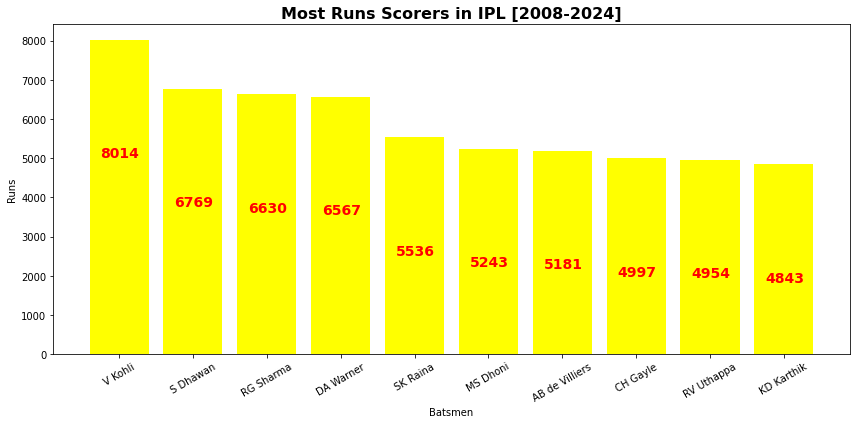

In [0]:
import numpy as np
most_runs_df = most_runs.toPandas()
plt.figure(figsize=(12,6))
plt.bar(most_runs_df.iloc[:10]['batter'], most_runs_df.iloc[:10]['Runs'] ,color='yellow' )
plt.xlabel('Batsmen')
plt.ylabel('Runs')
plt.title('Most Runs Scorers in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=30)
x = np.arange(10)
y = most_runs_df.iloc[:10]['Runs']
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v-3000 , str(v), fontweight='bold',color='red',fontsize=14)
plt.tight_layout()


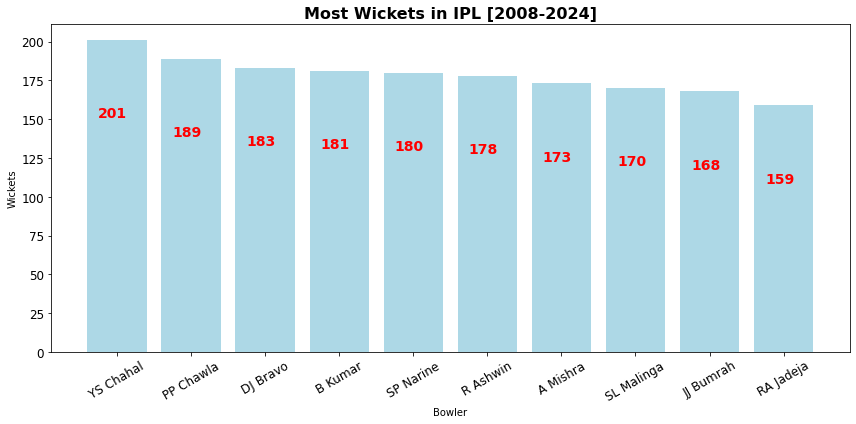

In [0]:
most_wickets_df = most_wickets.toPandas()
plt.figure(figsize=(12,6))
plt.bar(most_wickets_df.iloc[:10]['bowler'], most_wickets_df.iloc[:10]['Total_Wickets'] ,color='lightblue' )
plt.xlabel('Bowler')
plt.ylabel('Wickets')
plt.title('Most Wickets in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=30)
x = np.arange(10)
y = most_wickets_df.iloc[:10]['Total_Wickets']
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v-50 , str(v), fontweight='bold',color='red',fontsize=14)
plt.tight_layout()


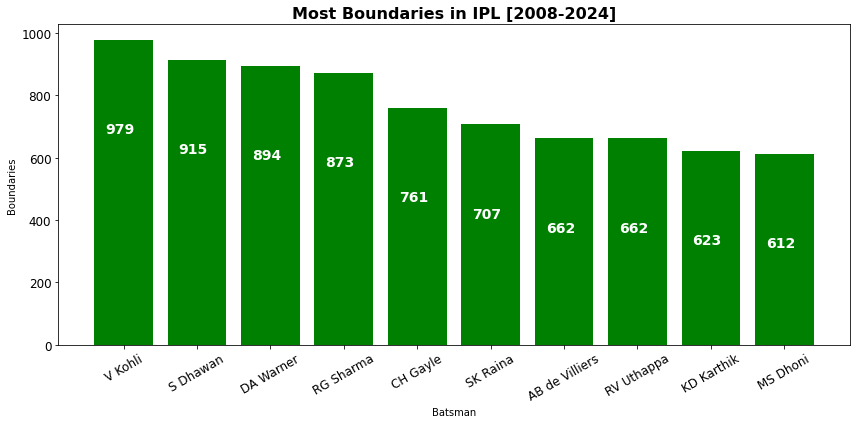

In [0]:
most_boundaries_df = most_boundaries.toPandas()

plt.figure(figsize=(12,6))
plt.bar(most_boundaries_df.iloc[:10]['batter'], most_boundaries_df.iloc[:10]['Boundaries_Hit'] ,color='green' )
plt.xlabel('Batsman')
plt.ylabel('Boundaries')
plt.title('Most Boundaries in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=30)
x = np.arange(10)
y = most_boundaries_df.iloc[:10]['Boundaries_Hit']
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v-300 , str(v), fontweight='bold',color='white',fontsize=14)
plt.tight_layout()


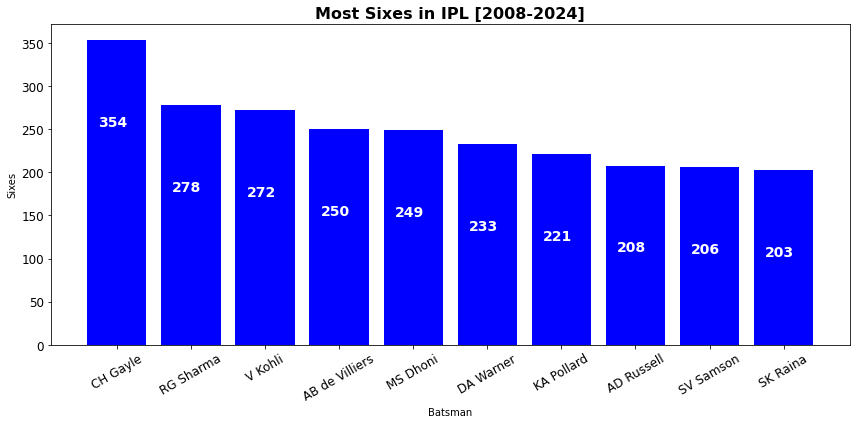

In [0]:
most_sixes_df = most_sixes.toPandas()

plt.figure(figsize=(12,6))
plt.bar(most_sixes_df.iloc[:10]['batter'], most_sixes_df.iloc[:10]['Sixes_Hit'] ,color='blue' )
plt.xlabel('Batsman')
plt.ylabel('Sixes')
plt.title('Most Sixes in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=30)
x = np.arange(10)
y = most_sixes_df.iloc[:10]['Sixes_Hit']
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v-100 , str(v), fontweight='bold',color='white',fontsize=14)
plt.tight_layout()


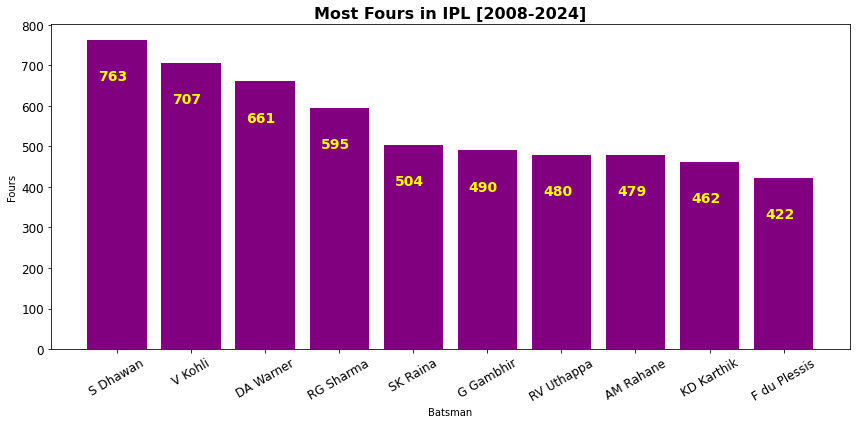

In [0]:
most_fours_df = most_fours.toPandas()

plt.figure(figsize=(12,6))
plt.bar(most_fours_df.iloc[:10]['batter'], most_fours_df.iloc[:10]['Fours_Hit'] ,color='purple' )
plt.xlabel('Batsman')
plt.ylabel('Fours')
plt.title('Most Fours in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=30)
x = np.arange(10)
y = most_fours_df.iloc[:10]['Fours_Hit']
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v-100 , str(v), fontweight='bold',color='yellow',fontsize=14)
plt.tight_layout()


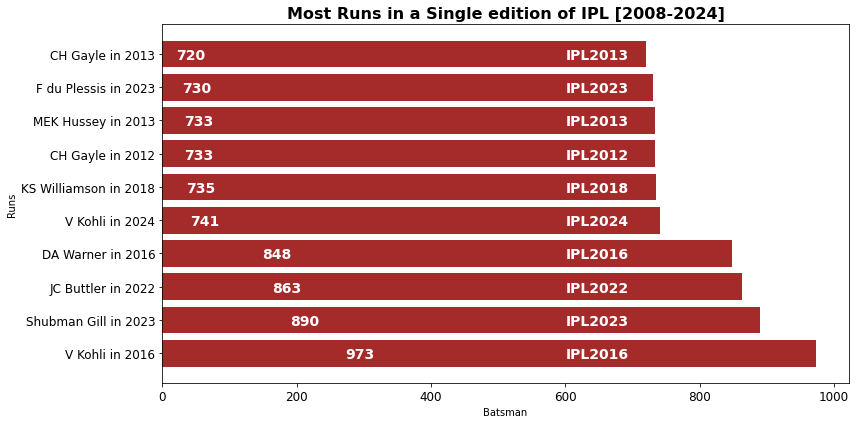

In [0]:
most_runs_in_an_IPL_season_df = most_runs_in_an_IPL_season.toPandas()

plt.figure(figsize=(12,6))
plt.barh(most_runs_in_an_IPL_season_df.iloc[:10]['batter']+' in '+most_runs_in_an_IPL_season_df.iloc[:10]['season'],most_runs_in_an_IPL_season_df.iloc[:10]['Most_Runs_in_a_Single_IPL_Season'] ,color='brown' )
plt.xlabel('Batsman')
plt.ylabel('Runs')
plt.title('Most Runs in a Single edition of IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=0)
x = np.arange(10)
y = most_runs_in_an_IPL_season_df.iloc[:10]['Most_Runs_in_a_Single_IPL_Season']
y_ = 'IPL' +most_runs_in_an_IPL_season_df.iloc[:10]['season']
for i, v in enumerate(y):
    plt.text(v-700, x[i] - 0.15 , str(v), fontweight='bold',color='white',fontsize=14)
for i, v in enumerate(y_):
    plt.text(600, x[i] - 0.15 , str(v), fontweight='bold',color='white',fontsize=14)
plt.tight_layout()

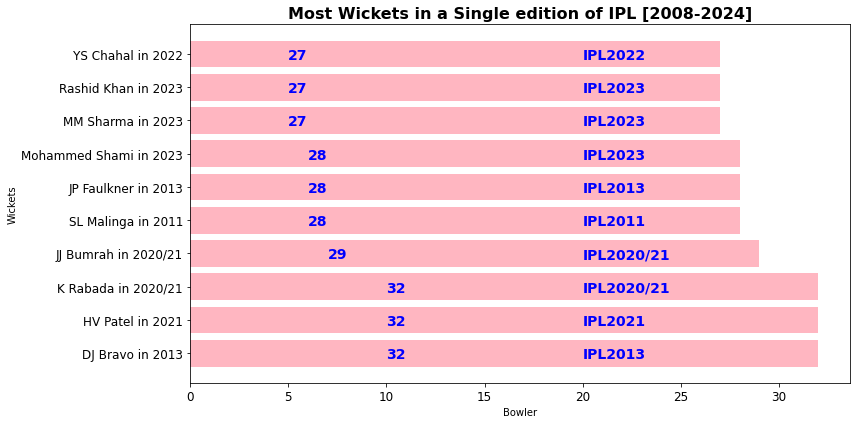

In [0]:
most_wickets_in_an_IPL_Season_df = most_wickets_in_an_IPL_Season.toPandas()

plt.figure(figsize=(12,6))
plt.barh(most_wickets_in_an_IPL_Season_df.iloc[:10]['bowler']+' in '+most_wickets_in_an_IPL_Season_df.iloc[:10]['season'],most_wickets_in_an_IPL_Season_df.iloc[:10]['Most_Wickets_in_a_Single_IPL_Season'] ,color='lightpink' )
plt.xlabel('Bowler')
plt.ylabel('Wickets')
plt.title('Most Wickets in a Single edition of IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=0)
x = np.arange(10)
y = most_wickets_in_an_IPL_Season_df.iloc[:10]['Most_Wickets_in_a_Single_IPL_Season']
y_ = 'IPL' +most_wickets_in_an_IPL_Season_df.iloc[:10]['season']
for i, v in enumerate(y):
    plt.text(v-22, x[i] - 0.15 , str(v), fontweight='bold',color='blue',fontsize=14)
for i, v in enumerate(y_):
    plt.text(20, x[i] - 0.15 , str(v), fontweight='bold',color='blue',fontsize=14)
plt.tight_layout()

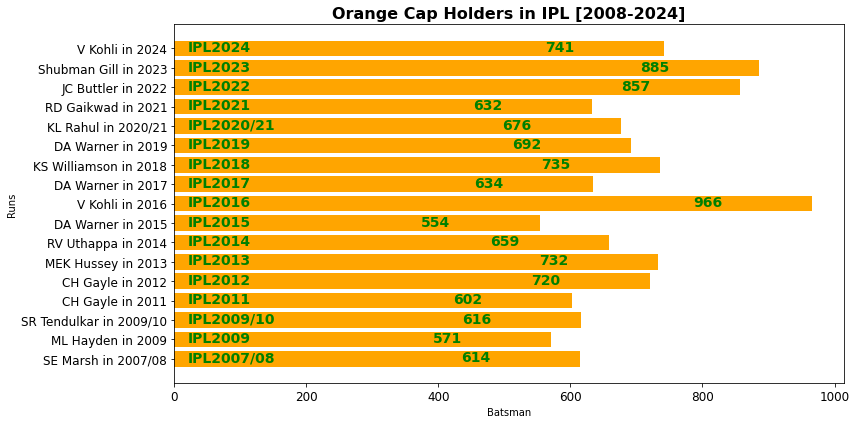

In [0]:
orange_cap_all_seasons_df = orange_cap_all_seasons.toPandas()
orange_cap_all_seasons_df

plt.figure(figsize=(12,6))
plt.barh(orange_cap_all_seasons_df['batter']+' in '+orange_cap_all_seasons_df['season'],orange_cap_all_seasons_df
['Most_Runs_in_a_Single_IPL_Season'] ,color='orange' )
plt.xlabel('Batsman')
plt.ylabel('Runs')
plt.title('Orange Cap Holders in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=0)
x = np.arange(17)
y = orange_cap_all_seasons_df['Most_Runs_in_a_Single_IPL_Season']
y_ = 'IPL' +orange_cap_all_seasons_df['season']
for i, v in enumerate(y):
    plt.text(v-180, x[i] - 0.15 , str(v), fontweight='bold',color='green',fontsize=14)
for i, v in enumerate(y_):
    plt.text(20, x[i] - 0.15 , str(v), fontweight='bold',color='green',fontsize=14)
plt.tight_layout()

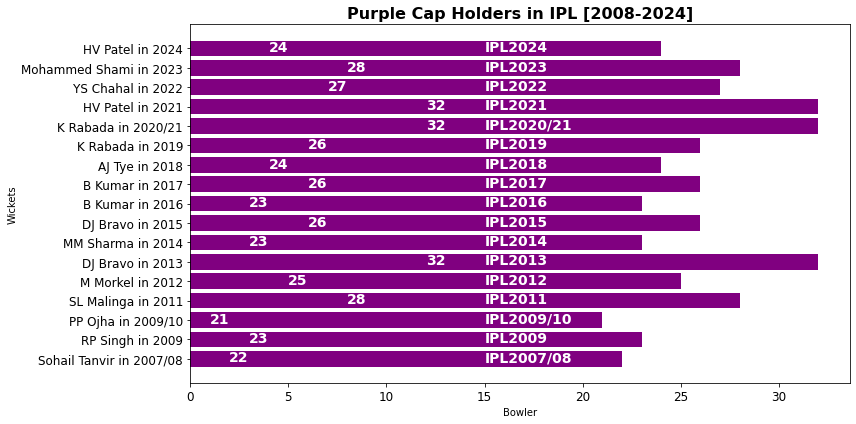

In [0]:
purple_cap_all_seasons_df = purple_cap_all_seasons.toPandas()
purple_cap_all_seasons_df

plt.figure(figsize=(12,6))
plt.barh(purple_cap_all_seasons_df['bowler']+' in '+purple_cap_all_seasons_df['season'],purple_cap_all_seasons_df
['Most_Wickets_in_a_Single_IPL_Season'] ,color='purple' )
plt.xlabel('Bowler')
plt.ylabel('Wickets')
plt.title('Purple Cap Holders in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=0)
x = np.arange(17)
y = purple_cap_all_seasons_df['Most_Wickets_in_a_Single_IPL_Season']
y_ = 'IPL' +purple_cap_all_seasons_df['season']
for i, v in enumerate(y):
    plt.text(v-20, x[i] - 0.15 , str(v), fontweight='bold',color='white',fontsize=14)
for i, v in enumerate(y_):
    plt.text(15, x[i] - 0.15 , str(v), fontweight='bold',color='white',fontsize=14)
plt.tight_layout()

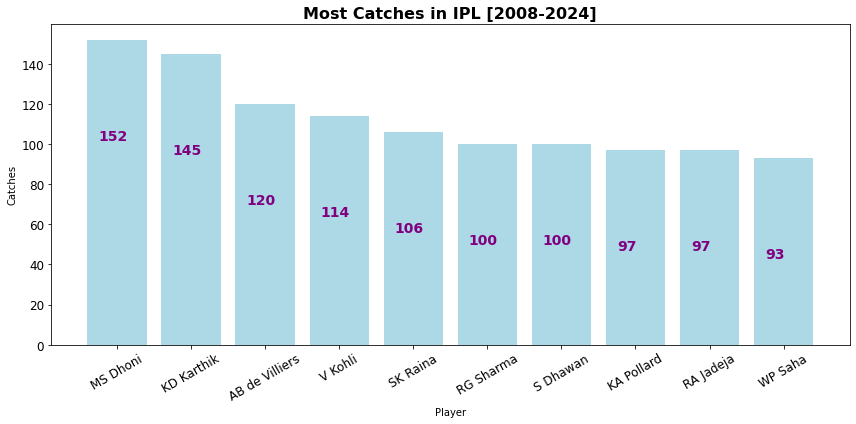

In [0]:
most_catches_df = most_catches.toPandas()

plt.figure(figsize=(12,6))
plt.bar(most_catches_df.iloc[:10]['fielder'], most_catches_df.iloc[:10]['Catches'] ,color='lightblue' )
plt.xlabel('Player')
plt.ylabel('Catches')
plt.title('Most Catches in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=30)
x = np.arange(10)
y = most_catches_df.iloc[:10]['Catches']
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v-50 , str(v), fontweight='bold',color='purple',fontsize=14)
plt.tight_layout()


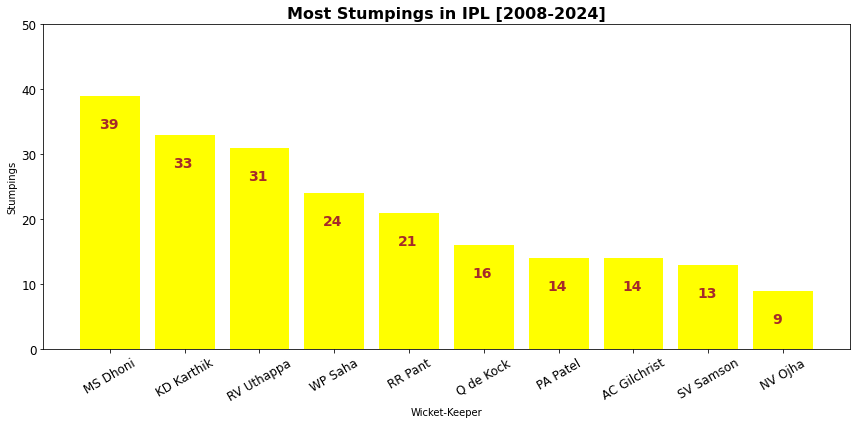

In [0]:
most_stumpings_df = most_stumpings.toPandas()

plt.figure(figsize=(12,6))
plt.bar(most_stumpings_df.iloc[:10]['fielder'], most_stumpings_df.iloc[:10]['Stumpings'] ,color='yellow' )
plt.xlabel('Wicket-Keeper')
plt.ylabel('Stumpings')
plt.title('Most Stumpings in IPL [2008-2024]',fontsize=16,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=30)
plt.ylim(0,50)
x = np.arange(10)
y = most_stumpings_df.iloc[:10]['Stumpings']
for i, v in enumerate(y):
    plt.text(x[i] - 0.15, v-5 , str(v), fontweight='bold',color='brown',fontsize=14)
plt.tight_layout()


<Figure size 864x432 with 0 Axes>

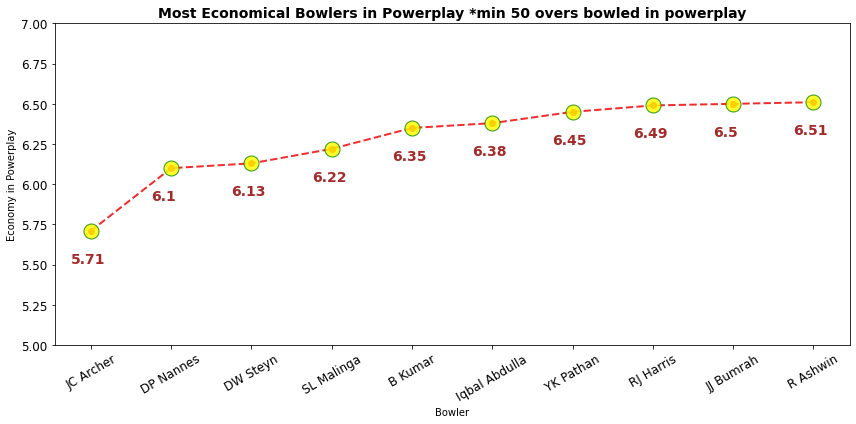

In [0]:
most_economical_baller_in_powerplay_df = most_economical_baller_in_powerplay.toPandas()

plt.figure(figsize=(12,6))
fig,ax  = plt.subplots(figsize=(12,6))
ax.plot(most_economical_baller_in_powerplay_df.iloc[:10]['bowler'], most_economical_baller_in_powerplay_df.iloc[:10]['Economy_in_Powerplay'],linewidth=2,color='#ee0000',alpha=.82,linestyle='dashed',marker='o',markersize=15,
            markerfacecolor='yellow',markeredgecolor='green')            
plt.scatter(most_economical_baller_in_powerplay_df.iloc[:10]['bowler'], most_economical_baller_in_powerplay_df.iloc[:10]['Economy_in_Powerplay'] ,color='red' )
plt.xlabel('Bowler')
plt.ylabel('Economy in Powerplay')
plt.title('Most Economical Bowlers in Powerplay *min 50 overs bowled in powerplay',fontsize=14,fontweight='bold')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.xticks(rotation=30)
plt.ylim(5,7)
x = np.arange(10)
y = most_economical_baller_in_powerplay_df.iloc[:10]['Economy_in_Powerplay']
for i, v in enumerate(y):
    plt.text(x[i] - 0.25, v-.2 , str(v), fontweight='bold',color='brown',fontsize=14)
plt.tight_layout()


In [0]:

over_wise_runs_by_every_team = ball_by_ball_df.groupby('batting_team','over').agg(
    sum('total_runs').alias('Runs_Scored'),
    round((avg('total_runs') * 6),2).alias('Run_Rate'),
).sort(desc('batting_team'),desc('over'))

over_wise_run_rate = ball_by_ball_df.groupby('over').agg(
    sum('total_runs').alias('Runs_Scored'),
    round((avg('total_runs') * 6),2).alias('Run_Rate'),
).sort(desc('over'))

overall = over_wise_run_rate.withColumn(
    "batting_team", when(over_wise_run_rate.Runs_Scored == -1, "Random").otherwise("All_Teams")
).toPandas()

SRH = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Sunrisers Hyderabad').toPandas()
CSK = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Chennai Super Kings').toPandas()
KKR = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Kolkata Knight Riders').toPandas()
RCB = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Royal Challengers Bengaluru').toPandas()
DC = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Delhi Capitals').toPandas()
MI = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Mumbai Indians').toPandas()
GT = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Gujarat Titans').toPandas()
LSG = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Lucknow Super Giants').toPandas()
RR = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Rajasthan Royals').toPandas()
PBKS = over_wise_runs_by_every_team.filter( over_wise_runs_by_every_team.batting_team ==  'Punjab Kings').toPandas()



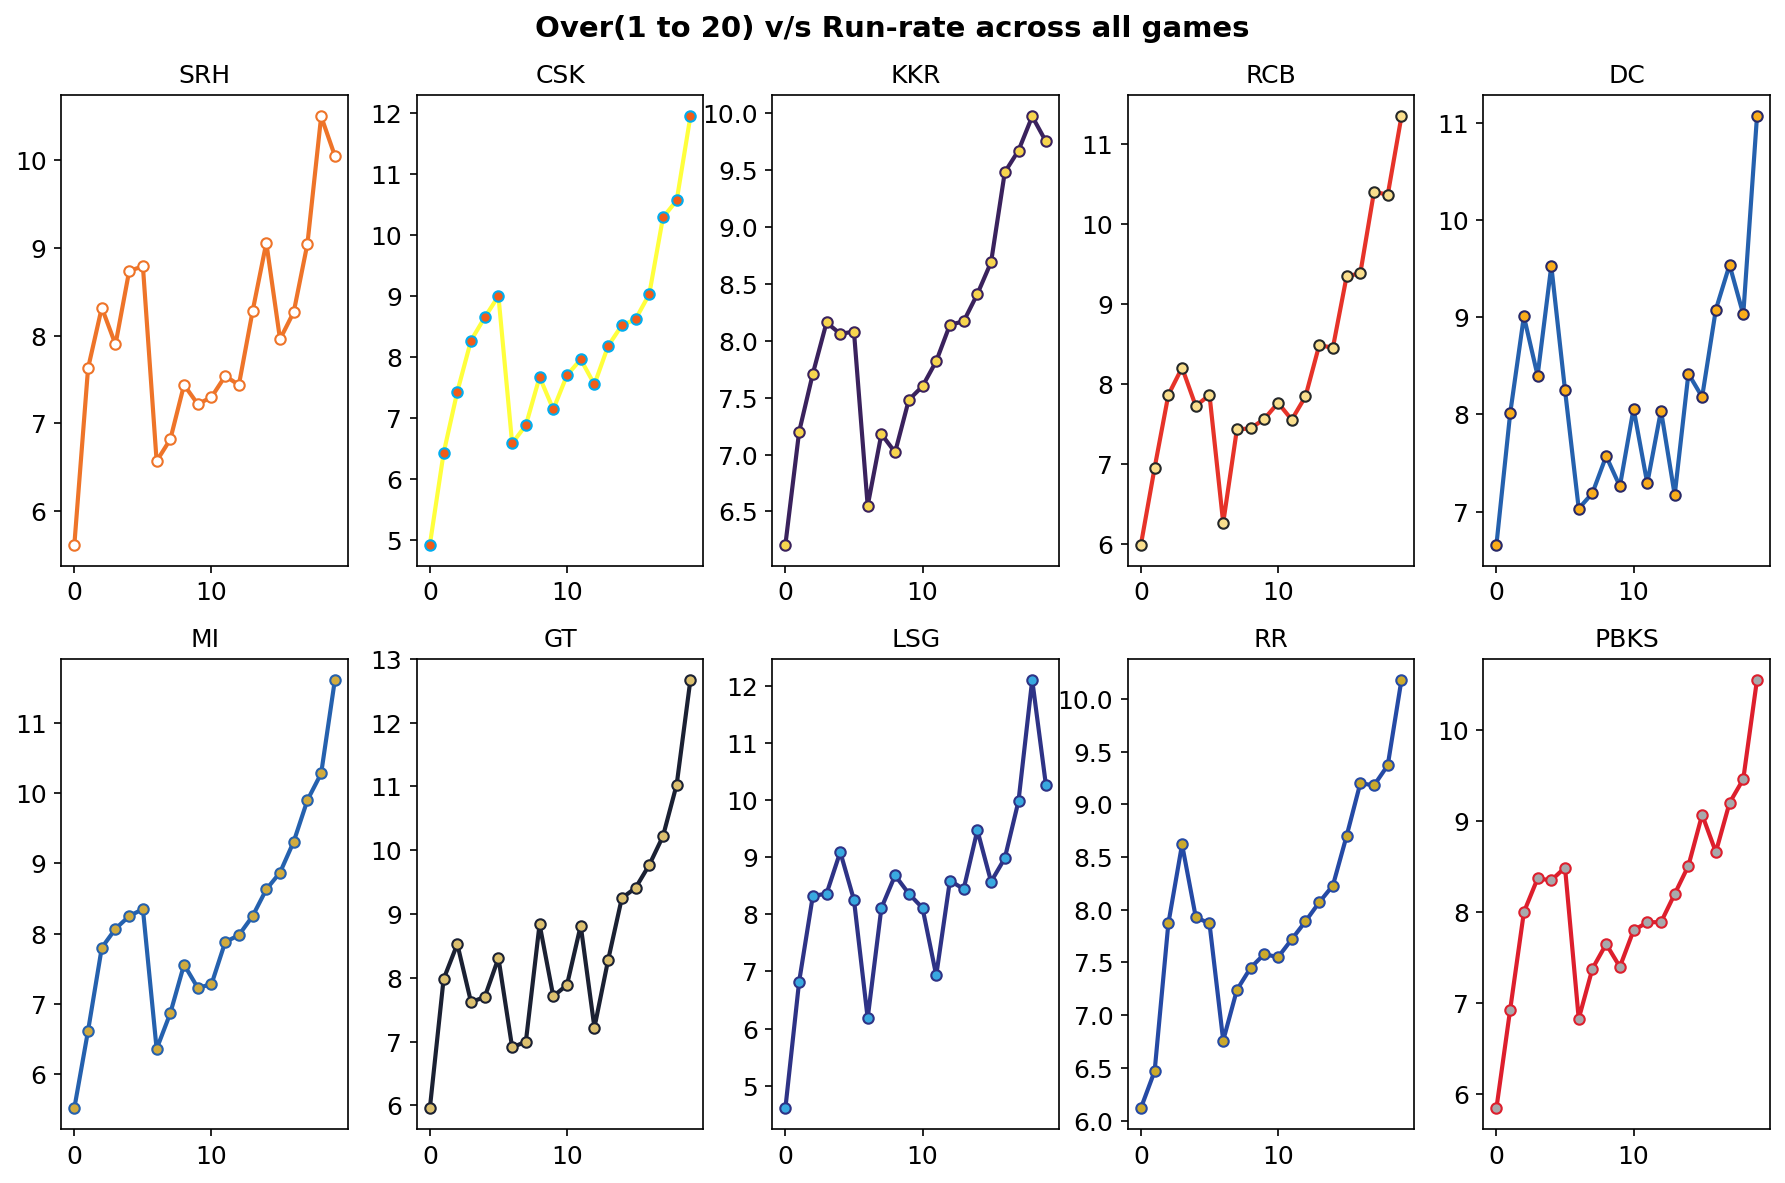

In [0]:
fig,ax  = plt.subplots(nrows=2,ncols=5,figsize=(12,8),dpi=150)
fig.suptitle('Over(1 to 20) v/s Run-rate across all games',fontsize=14,fontweight='bold')
ax[0,0].plot(SRH.over,SRH.Run_Rate,color='#EE7429',lw=2,marker='.',markerfacecolor='white',markersize=10)
ax[0,0].set_title('SRH')
ax[0,1].plot(CSK.over,CSK.Run_Rate,color='#FFFF3C',lw=2,marker='.',markeredgecolor='#00ADEF',markerfacecolor='#F15C19',markersize=10)
ax[0,1].set_title('CSK')
ax[0,2].plot(KKR.over,KKR.Run_Rate,color='#3A225D',lw=2,marker='.',markerfacecolor='#F7D54E',markersize=10)
ax[0,2].set_title('KKR')
ax[0,3].plot(RCB.over,RCB.Run_Rate,color='#E63329',lw=2,marker='.',markerfacecolor='#FADF8D',markeredgecolor='#252829',markersize=10)
ax[0,3].set_title('RCB')
ax[0,4].plot(DC.over,DC.Run_Rate,color='#2561AE',markeredgecolor='#282968',markerfacecolor='#FAAD1B',lw=2,marker='.',markersize=10)
ax[0,4].set_title('DC')
ax[1,0].plot(MI.over,MI.Run_Rate,color='#2561AE',lw=2,marker='.',markersize=10,markerfacecolor='#D1AB3E') #D1AB3E-golden
ax[1,0].set_title('MI')
ax[1,1].plot(GT.over,GT.Run_Rate,color='#1B2133',lw=2,marker='.',markersize=10,markerfacecolor='#DCC06F') #DCC06F-golden
ax[1,1].set_title('GT')
ax[1,2].plot(LSG.over,LSG.Run_Rate,color='#2E3386',lw=2,marker='.',markerfacecolor='#39A9E0',markersize=10) #39A9E0-blue
ax[1,2].set_title('LSG')
ax[1,3].plot(RR.over,RR.Run_Rate,color='#254AA5',lw=2,marker='.',markerfacecolor='#CBA92B',markersize=10) #CBA92B-GOLDEN
ax[1,3].set_title('RR')
ax[1,4].plot(PBKS.over,PBKS.Run_Rate,color='#DD1F2D',lw=2,marker='.',markerfacecolor='#A7A9AC',markersize=10)
ax[1,4].set_title('PBKS')

plt.tight_layout()

Out[173]: Text(0.5, 1.0, 'Over-Wise Average Run-rate across all games')

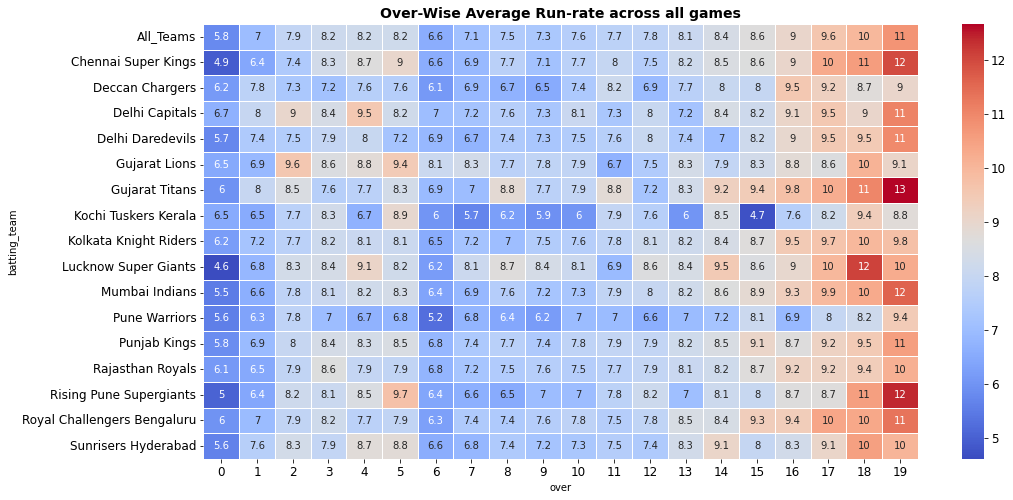

In [0]:
plt.figure(figsize=(16,8))
df = pd.concat([over_wise_runs_by_every_team.toPandas(),overall],axis=0).pivot_table(values='Run_Rate',index='batting_team',columns='over')
sns.heatmap(df,cmap='coolwarm',annot=True,lw=.5)
plt.title('Over-Wise Average Run-rate across all games',fontsize=14,fontweight='bold')

Out[234]: Text(0.5, 1.0, 'Average Number of Wickets taken viz Overs : [1-4],[5-8],[9-12],[13-16],[17-20]')

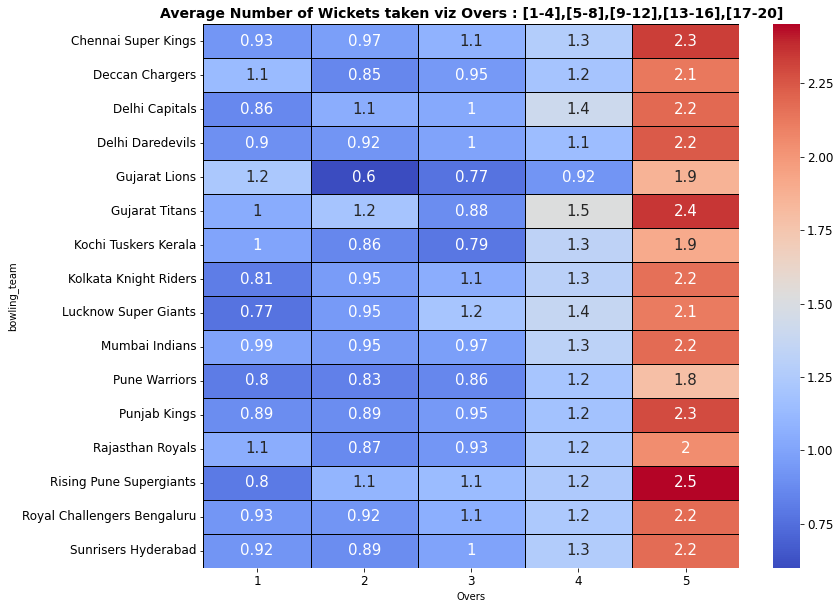

In [0]:
#Bowling stats
over_wise_wickets_taken = ball_by_ball_df.withColumn("Overs", ceil((col('over')+1)/4) ).groupby('bowling_team','Overs').agg(
    round((avg('is_wicket') * 6 * 4),5).alias('Wickets'),
).sort(desc('bowling_team'),desc('Overs')).toPandas().pivot_table(values='Wickets',index='bowling_team',columns='Overs')
plt.figure(figsize=(12,10))
sns.heatmap(over_wise_wickets_taken,cmap='coolwarm',annot=True,lw=1,linecolor='black',annot_kws={'size': 15})
plt.title('Average Number of Wickets taken viz Overs : [1-4],[5-8],[9-12],[13-16],[17-20]',fontsize=14,fontweight='bold')

Out[241]: Text(0.5, 1.0, 'Average runs conceeded per over')<Figure size 864x720 with 0 Axes>

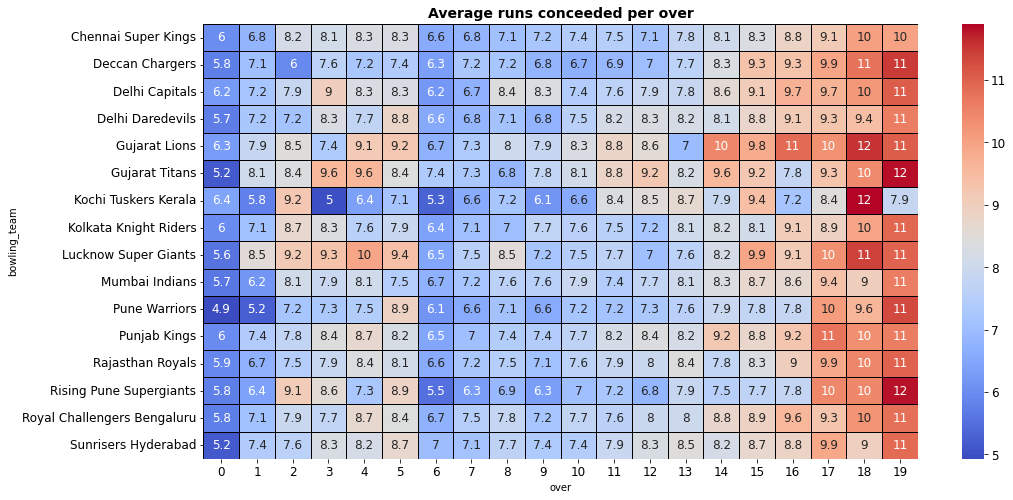

In [0]:
#Bowling stats
avg_runs_conceeded = ball_by_ball_df.groupby('bowling_team','over').agg(
    round((avg('total_runs')*6),2).alias('avg_runs'),
).sort(desc('bowling_team'),desc('over')).toPandas().pivot_table(values='avg_runs',index='bowling_team',columns='over')
plt.figure(figsize=(12,10))
plt.figure(figsize=(16,8))
sns.heatmap(avg_runs_conceeded,cmap='coolwarm',annot=True,lw=1,linecolor='black',annot_kws={'size': 12})
plt.title('Average runs conceeded per over',fontsize=14,fontweight='bold')

Out[251]: Text(0.5, 1.0, 'Average Number of Wickets Lost viz Overs : [1-4],[5-8],[9-12],[13-16],[17-20]')

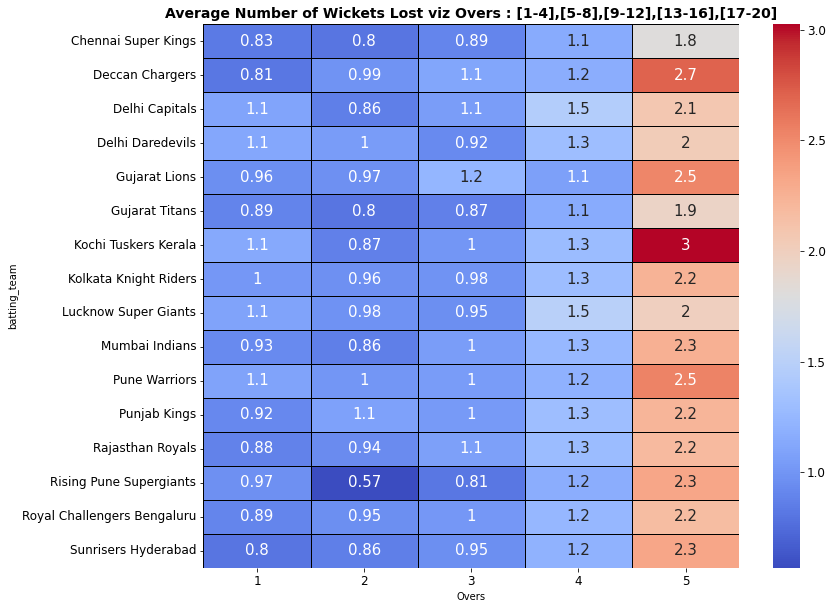

In [0]:

#Batting stats
over_wise_fow = ball_by_ball_df.withColumn("Overs", ceil((col('over')+1)/4) ).groupby('batting_team','Overs').agg(
    round((avg('is_wicket') * 6 * 4),5).alias('Wickets'),
).sort(desc('batting_team'),desc('Overs')).toPandas().pivot_table(values='Wickets',index='batting_team',columns='Overs')
plt.figure(figsize=(12,10))
sns.heatmap(over_wise_fow,cmap='coolwarm',annot=True,lw=1,linecolor='black',annot_kws={'size': 15})
plt.title('Average Number of Wickets Lost viz Overs : [1-4],[5-8],[9-12],[13-16],[17-20]',fontsize=14,fontweight='bold')